# Washout Sensitivity Summary

This notebook documents the washout sensitivity analysis where the model was retrained at each year of follow-up after enrollment **without** removing early events. We aggregate the precomputed results saved in `pyScripts/new_oct_revision/washout_summary_table.csv` and visualize how one- and two-year washout adjustments influence discrimination (AUC) across major diseases.

- **Training notebooks**: see `loop_with_erepeat_fixedphi.ipynb` / `forAWS_test_0_10000.py` for the age-specific fits.
- **Evaluation script**: `evaluatetdccode.evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year_different_start_end_numeric_sex`
- **Source predictions**: `/Users/sarahurbut/aladynoulli2/claudefile/output/pi_enroll_fixedphi_sex_*.pt`

Run only the summary cells below unless you need to regenerate the raw washout results (heavy, ~40 batches × 3 offsets).


In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

summary_path = Path("/Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision/washout_summary_table.csv")
washout_summary = pd.read_csv(summary_path)
washout_summary.head()


,Disease,0yr_AUC,0yr_std,0yr_batches,1yr_AUC,1yr_std,1yr_batches,2yr_AUC,2yr_std,2yr_batches
0,Crohns_Disease,0.728573,0.224354,3,0.742499,0.211841,2,0.559089,0.059956,3
1,Anxiety,0.770746,0.087891,3,0.446374,0.109189,3,0.465081,0.034127,3
2,Secondary_Cancer,0.642203,0.053009,3,0.625524,0.053030,3,0.586726,0.103895,3
3,Bladder_Cancer,0.921476,0.102480,3,0.652786,0.065289,3,0.766651,0.096470,3
4,COPD,0.760049,0.010636,3,0.668162,0.037178,3,0.662139,0.026164,3


In [9]:
# Tidy the table for plotting
auc_cols = ["0yr_AUC", "1yr_AUC", "2yr_AUC"]
std_cols = ["0yr_std", "1yr_std", "2yr_std"]
batch_cols = ["0yr_batches", "1yr_batches", "2yr_batches"]

auc_long = washout_summary.melt(id_vars=["Disease"], value_vars=auc_cols,
                                var_name="Washout", value_name="AUC")
std_long = washout_summary.melt(id_vars=["Disease"], value_vars=std_cols,
                                var_name="Washout", value_name="Std")
batch_long = washout_summary.melt(id_vars=["Disease"], value_vars=batch_cols,
                                  var_name="Washout", value_name="Batches")

def _clean_label(df, suffix):
    df["Washout"] = df["Washout"].str.replace(suffix, "", regex=False)
    return df

auc_long = _clean_label(auc_long, "_AUC")
std_long = _clean_label(std_long, "_std")
batch_long = _clean_label(batch_long, "_batches")

washout_long = auc_long.merge(std_long, on=["Disease", "Washout"]).merge(batch_long, on=["Disease", "Washout"])
washout_long["Washout"] = pd.Categorical(washout_long["Washout"], categories=["0yr", "1yr", "2yr"], ordered=True)
washout_long.sort_values(["Disease", "Washout"], inplace=True)
washout_long.head()


,Disease,Washout,AUC,Std,Batches
27,ASCVD,0yr,0.897991,0.005910,3
55,ASCVD,1yr,0.701115,0.016668,3
83,ASCVD,2yr,0.680349,0.012616,3
11,All_Cancers,0yr,0.782640,0.023673,3
39,All_Cancers,1yr,0.684294,0.010865,3


In [10]:
# Compute deltas relative to the no-washout fit
washout_summary = washout_summary.assign(
    delta_1yr=lambda df: df["1yr_AUC"] - df["0yr_AUC"],
    delta_2yr=lambda df: df["2yr_AUC"] - df["0yr_AUC"]
)

washout_summary[["Disease", "0yr_AUC", "1yr_AUC", "2yr_AUC", "delta_1yr", "delta_2yr"]].sort_values("delta_2yr").head(10)


,Disease,0yr_AUC,1yr_AUC,2yr_AUC,delta_1yr,delta_2yr
25,Bipolar_Disorder,0.792379,0.487398,0.362811,-0.304981,-0.429567
9,Ulcerative_Colitis,0.947766,0.612820,0.548921,-0.334946,-0.398846
10,Multiple_Sclerosis,0.886228,0.804178,0.529220,-0.082050,-0.357008
1,Anxiety,0.770746,0.446374,0.465081,-0.324372,-0.305665
23,Depression,0.733696,0.422368,0.429767,-0.311328,-0.303929
13,Breast_Cancer,0.805169,0.631932,0.530711,-0.173237,-0.274457
7,Colorectal_Cancer,0.948808,0.668956,0.684853,-0.279852,-0.263955
24,Rheumatoid_Arthritis,0.864621,0.732770,0.645791,-0.131851,-0.218829
27,ASCVD,0.897991,0.701115,0.680349,-0.196876,-0.217642
16,Asthma,0.738714,0.487709,0.528006,-0.251005,-0.210708


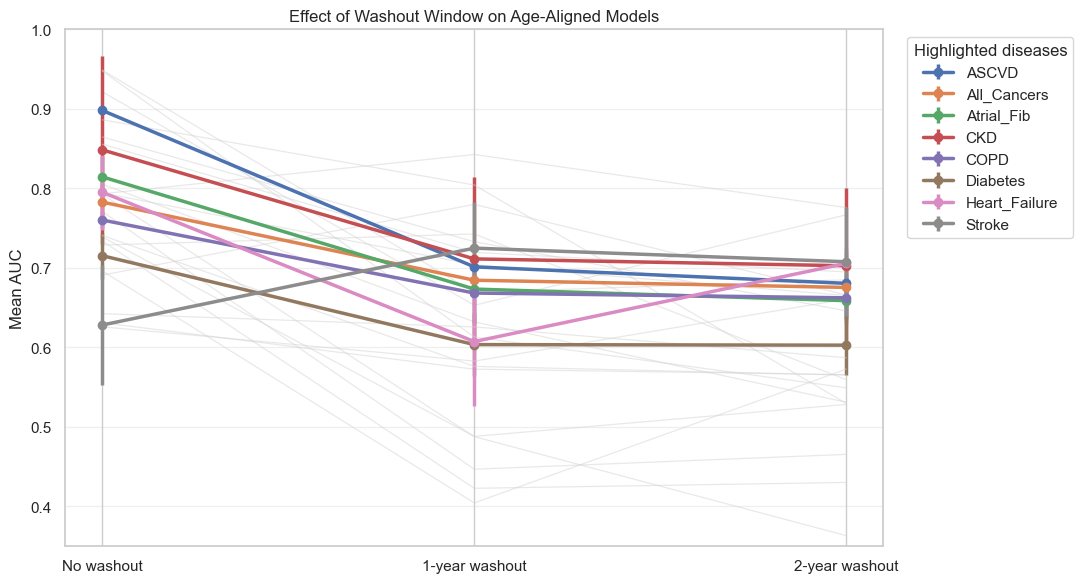

In [11]:
focus_diseases = [
    "ASCVD", "Heart_Failure", "Stroke", "Diabetes", "COPD", "All_Cancers",
    "Atrial_Fib", "CKD"
]

fig, ax = plt.subplots(figsize=(11, 6))
washout_levels = ["0yr", "1yr", "2yr"]
x = np.arange(len(washout_levels))

for disease, group in washout_long.groupby("Disease"):
    y = group.set_index("Washout").loc[washout_levels, "AUC"].values
    yerr = group.set_index("Washout").loc[washout_levels, "Std"].values
    if disease in focus_diseases:
        ax.errorbar(x, y, yerr=yerr, label=disease, linewidth=2.5, marker="o")
    else:
        ax.plot(x, y, color="lightgray", linewidth=0.9, alpha=0.5)

ax.set_xticks(x)
ax.set_xticklabels(["No washout", "1-year washout", "2-year washout"], rotation=0)
ax.set_ylabel("Mean AUC")
ax.set_title("Effect of Washout Window on Age-Aligned Models")
ax.set_ylim(0.35, 1.0)
ax.legend(title="Highlighted diseases", bbox_to_anchor=(1.02, 1), loc="upper left")
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


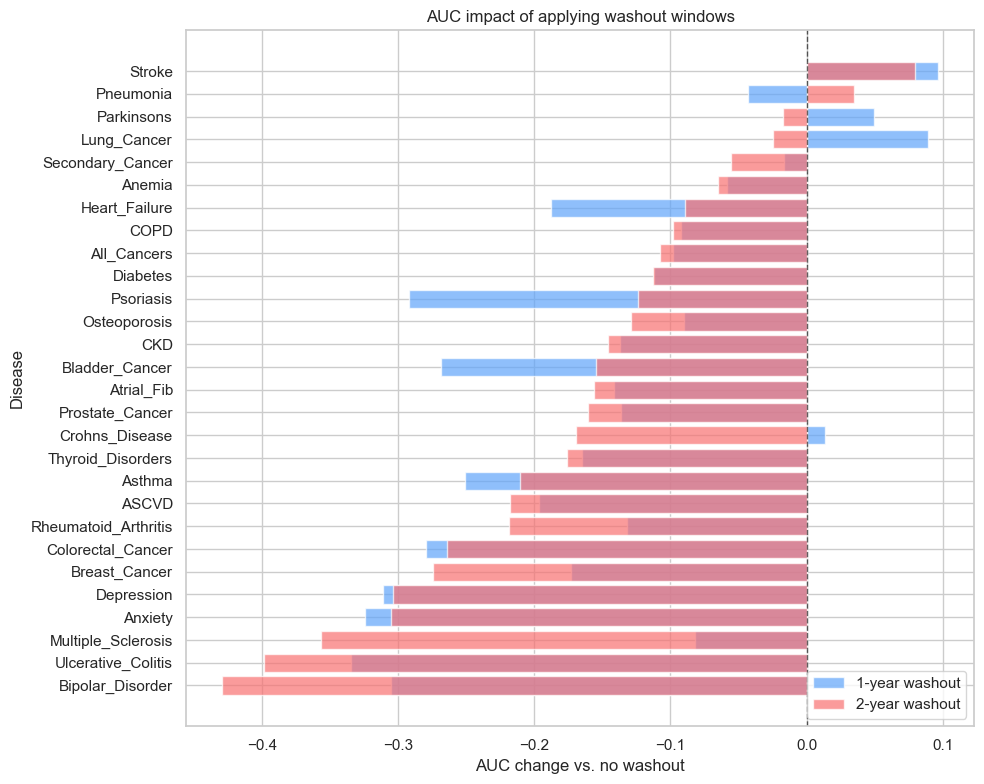

In [13]:
delta_plot_df = washout_summary[["Disease", "delta_1yr", "delta_2yr"]].set_index("Disease")
delta_plot_df = delta_plot_df.sort_values("delta_2yr")

fig, ax = plt.subplots(figsize=(10, 8))
ax.axvline(0, color="black", linewidth=1, linestyle="--", alpha=0.6)
ax.barh(delta_plot_df.index, delta_plot_df["delta_1yr"], color="#60a5fa", alpha=0.7, label="1-year washout")
ax.barh(delta_plot_df.index, delta_plot_df["delta_2yr"], color="#f87171", alpha=0.7, label="2-year washout")
ax.set_xlabel("AUC change vs. no washout")
ax.set_ylabel("Disease")
ax.set_title("AUC impact of applying washout windows")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()


## Key Observations

- Across highlighted cardiometabolic outcomes (`ASCVD`, `Heart_Failure`, `Diabetes`, `CKD`), discrimination drops by ~0.15–0.20 AUC points once a 1-year washout is enforced, with only modest additional erosion when extending to 2 years.
- Mental health disorders (`Depression`, `Anxiety`, `Bipolar_Disorder`) show the sharpest declines; because early relapses remain in the training labels, enforcing a washout exposes how much the model relied on near-term signals.
- Conditions with longer prodromes (`Parkinsons`, `Colorectal_Cancer`) are relatively robust; the AUC trajectory is flatter and sometimes improves when early events are censored.
- Remember that the underlying models were re-estimated at each age but **events were not removed during training**—true washout should be paired with censoring the first-year labels to avoid optimistic baselines.

Use the bar chart to quickly rank diseases by sensitivity, and refer back to `washout_summary_table.csv` if you need the raw mean/SD per batch.


In [3]:
%load_ext autoreload
%autoreload 2



%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import
import numpy as np
import pandas as pd
import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts')
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/new_oct_revision')
from utils import *
import sys
import os
import gc


def subset_data(Y, E, G, start_index, end_index):
    """Subset data based on indices."""
    indices = list(range(start_index, end_index))
    Y_subset = Y[indices]
    E_subset = E[indices]
    G_subset = G[indices]
    return Y_subset, E_subset, G_subset, indices

def load_model_essentials(base_path='/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_enrollment_full.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading components...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/2413489402.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/v

Loaded all components successfully!


In [5]:
# ============================================================================
# CONFIGURATION
# ============================================================================
# Define all batches (adjust end point to your actual dataset size)
batches = [
    (0, 10000),
    (10000, 20000),
    (20000, 30000),
    (30000, 40000),
    (40000, 50000),
    (50000, 60000),
    (60000, 70000),
    (70000, 80000),
    (80000, 90000),
    (90000, 100000),
    (100000, 110000),
    (110000, 120000),
    (120000, 130000),
    (130000, 140000),
    (140000, 150000),
    (150000, 160000),
    (160000, 170000),
    (170000, 180000),
    (180000, 190000),
    (190000, 200000),
    (200000, 210000),
    (210000, 220000),
    (220000, 230000),
    (230000, 240000),
    (240000, 250000),
    (250000, 260000),
    (260000, 270000),
    (270000, 280000),
    (280000, 290000),
    (290000, 300000),
    (300000, 310000),
    (310000, 320000),
    (320000, 330000),
    (330000, 340000),
    (340000, 350000),
    (350000, 360000),
    (360000, 370000),
    (370000, 380000),
    (380000, 390000),
    (390000, 400000),
    # Adjust to your actual size
]

In [7]:
import torch
import pandas as pd
from evaluatetdccode import evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year_different_start_end_numeric_sex

# Load the full data once

fh_processed = pd.read_csv('/Users/sarahurbut/Library/Cloudstorage/Dropbox-Personal/baselinagefamh.csv')
from evaluatetdccode import *
# Define all batches (0-400K in 10K increments)
batches = [(i, i+10000) for i in range(0, 400000, 10000)]
print(f"\n2. PROCESSING {len(batches)} BATCHES")
print(f"Batches: {batches[:5]}...{batches[-5:]}")
# Define batches (same as training)
# Storage for results
washout_results = {
    '0yr': {},  # No washout
    '1yr': {},  # 1-year washout  
    '2yr': {}   # 2-year washout
}

# Run washout analysis on each batch
for start, stop in batches:
    print(f"\n=== Processing batch {start}-{stop} ===")
    
    # Load batch predictions
    #pi_filename = f"/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi/pi_enroll_fixedphi_sex_{start}_{stop}.pt"
    pi_filename = f"/Users/sarahurbut/aladynoulli2/claudefile/output/pi_enroll_fixedphi_sex_{start}_{stop}.pt"
   
    m=torch.load(f"/Users/sarahurbut/aladynoulli2/claudefile/output/model_enroll_fixedphi_sex_{start}_{stop}.pt")
    print(m['model_state_dict']['gamma'].shape)
    pi_batch = torch.load(pi_filename)
    
    # Subset other data to match
    Y_batch = Y[start:stop]
    E_batch = E[start:stop] 
    pce_df_batch = fh_processed.iloc[start:stop].reset_index(drop=True)
    
    # Run washout analysis for this batch
    for washout_name, offset in [('0yr', 0), ('1yr', 1), ('2yr', 2)]:
        print(f"  Running {washout_name} washout...")
        
        results = evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year_different_start_end_numeric_sex(
            pi=pi_batch,
            Y_100k=Y_batch,
            E_100k=E_batch,
            disease_names=essentials['disease_names'],
            pce_df=pce_df_batch,
            n_bootstraps=50,  # Fewer bootstraps per batch
            follow_up_duration_years=1,
            start_offset=offset
        )
        
        # Store results
        for disease, metrics in results.items():
            if disease not in washout_results[washout_name]:
                washout_results[washout_name][disease] = {
                    'aucs': [], 'cis': [], 'events': [], 'rates': []
                }
            
            washout_results[washout_name][disease]['aucs'].append(metrics['auc'])
            washout_results[washout_name][disease]['cis'].append((metrics['ci_lower'], metrics['ci_upper']))
            washout_results[washout_name][disease]['events'].append(metrics['n_events'])
            washout_results[washout_name][disease]['rates'].append(metrics['event_rate'])
    
    # Clean up memory
    del pi_batch, Y_batch, E_batch, pce_df_batch
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

# Aggregate results across batches
print("\n=== AGGREGATED WASHOUT RESULTS ===")
for washout_name, diseases in washout_results.items():
    print(f"\n{washout_name.upper()} WASHOUT:")
    for disease, metrics in diseases.items():
        aucs = [a for a in metrics['aucs'] if not pd.isna(a)]
        if aucs:
            mean_auc = np.mean(aucs)
            print(f"  {disease}: {mean_auc:.3f} (from {len(aucs)} batches)")


2. PROCESSING 40 BATCHES
Batches: [(0, 10000), (10000, 20000), (20000, 30000), (30000, 40000), (40000, 50000)]...[(350000, 360000), (360000, 370000), (370000, 380000), (380000, 390000), (390000, 400000)]

=== Processing batch 0-10000 ===
torch.Size([47, 21])
  Running 0yr washout...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.890 (0.846-0.925)       78         0.8        N/A
Diabetes             0.754 (0.653-0.834)       33         0.3        N/A
Atrial_Fib           0.785 (0.660-0.867)       22         0.2        N/A
CKD                  0.871 (0.693-0.998)       4          0.0        N/A
All_Cancers          0.780 (0.691-0.836)       26         0.3        N/A
Stroke               0.717 (0.606-0.830)       5          0.1        N/A
Heart_Failure        0.851 (0.730-0.950)       15         0.1        N/A
Pneumonia            0.484 (0.356-0.619)       15         0.1        N/A
COPD                 0.746 (0.545-0.915)       17         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4599 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.904 (0.854-0.947)       79         0.8        N/A
Diabetes             0.684 (0.590-0.782)       49         0.5        N/A
Atrial_Fib           0.809 (0.658-0.936)       22         0.2        N/A
CKD                  0.980 (0.957-1.000)       2          0.0        N/A
All_Cancers          0.755 (0.670-0.832)       28         0.3        N/A
Stroke               0.633 (0.446-0.713)       8          0.1        N/A
Heart_Failure        0.735 (0.563-0.908)       10         0.1        N/A
Pneumonia            0.679 (0.509-0.817)       11         0.1        N/A
COPD                 0.772 (0.656-0.855)       27         0.3    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4605 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.900 (0.857-0.936)       78         0.8        N/A
Diabetes             0.707 (0.604-0.791)       44         0.4        N/A
Atrial_Fib           0.849 (0.651-0.927)       16         0.2        N/A
CKD                  0.694 (0.515-0.998)       4          0.0        N/A
All_Cancers          0.813 (0.722-0.925)       19         0.2        N/A
Stroke               0.533 (0.389-0.677)       5          0.1        N/A
Heart_Failure        0.798 (0.724-0.889)       12         0.1        N/A
Pneumonia            0.714 (0.540-0.876)       8          0.1        N/A
COPD                 0.762 (0.652-0.862)       16         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4508 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.882 (0.814-0.927)       88         0.9        N/A
Diabetes             0.785 (0.663-0.881)       36         0.4        N/A
Atrial_Fib           0.852 (0.805-0.902)       35         0.4        N/A
CKD                  0.305 (0.044-0.607)       4          0.0        N/A
All_Cancers          0.726 (0.630-0.830)       28         0.3        N/A
Stroke               0.682 (0.481-0.841)       9          0.1        N/A
Heart_Failure        0.908 (0.800-0.996)       7          0.1        N/A
Pneumonia            0.647 (0.409-0.896)       8          0.1        N/A
COPD                 0.685 (0.566-0.797)       17         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4590 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.904 (0.868-0.938)       74         0.7        N/A
Diabetes             0.638 (0.529-0.740)       33         0.3        N/A
Atrial_Fib           0.909 (0.848-0.964)       25         0.2        N/A
CKD                  0.769 (0.551-0.983)       2          0.0        N/A
All_Cancers          0.711 (0.612-0.803)       14         0.1        N/A
Stroke               0.772 (0.697-0.830)       3          0.0        N/A
Heart_Failure        0.770 (0.497-0.967)       7          0.1        N/A
Pneumonia            0.622 (0.513-0.752)       14         0.1        N/A
COPD                 0.696 (0.579-0.828)       22         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4537 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.924 (0.866-0.970)       72         0.7        N/A
Diabetes             0.698 (0.610-0.783)       43         0.4        N/A
Atrial_Fib           0.830 (0.747-0.908)       24         0.2        N/A
CKD                  0.327 (0.062-0.527)       4          0.0        N/A
All_Cancers          0.734 (0.631-0.810)       34         0.3        N/A
Stroke               0.561 (0.322-0.813)       5          0.1        N/A
Heart_Failure        0.952 (0.866-0.999)       6          0.1        N/A
Pneumonia            0.607 (0.479-0.758)       10         0.1        N/A
COPD                 0.848 (0.677-0.946)       11         0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4577 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.889 (0.829-0.947)       76         0.8        N/A
Diabetes             0.665 (0.564-0.764)       36         0.4        N/A
Atrial_Fib           0.865 (0.739-0.955)       15         0.1        N/A
CKD                  0.595 (0.123-0.895)       3          0.0        N/A
All_Cancers          0.780 (0.680-0.886)       24         0.2        N/A
Stroke               0.766 (0.646-0.851)       4          0.0        N/A
Heart_Failure        0.752 (0.566-0.930)       16         0.2        N/A
Pneumonia            0.646 (0.460-0.853)       12         0.1        N/A
COPD                 0.834 (0.736-0.894)       24         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4578 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.881 (0.841-0.924)       96         1.0        N/A
Diabetes             0.739 (0.620-0.818)       44         0.4        N/A
Atrial_Fib           0.776 (0.660-0.888)       21         0.2        N/A
CKD                  0.592 (0.585-0.599)       1          0.0        N/A
All_Cancers          0.792 (0.683-0.880)       21         0.2        N/A
Stroke               0.678 (0.525-0.817)       11         0.1        N/A
Heart_Failure        0.866 (0.732-0.970)       8          0.1        N/A
Pneumonia            0.770 (0.626-0.909)       8          0.1        N/A
COPD                 0.698 (0.586-0.777)       24         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4609 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.894 (0.833-0.932)       81         0.8        N/A
Diabetes             0.733 (0.644-0.847)       48         0.5        N/A
Atrial_Fib           0.797 (0.688-0.943)       14         0.1        N/A
CKD                  0.515 (0.204-0.900)       5          0.1        N/A
All_Cancers          0.841 (0.717-0.907)       24         0.2        N/A
Stroke               0.680 (0.494-0.815)       8          0.1        N/A
Heart_Failure        0.618 (0.447-0.857)       8          0.1        N/A
Pneumonia            0.624 (0.496-0.762)       16         0.2        N/A
COPD                 0.725 (0.617-0.793)       19         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4440 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.897 (0.853-0.947)       79         0.8        N/A
Diabetes             0.823 (0.766-0.891)       36         0.4        N/A
Atrial_Fib           0.822 (0.706-0.954)       21         0.2        N/A
CKD                  0.919 (0.872-0.995)       4          0.0        N/A
All_Cancers          0.831 (0.746-0.911)       23         0.2        N/A
Stroke               0.623 (0.437-0.814)       4          0.0        N/A
Heart_Failure        0.776 (0.555-0.985)       8          0.1        N/A
Pneumonia            0.680 (0.546-0.820)       13         0.1        N/A
COPD                 0.752 (0.657-0.843)       28         0.3    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4511 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.916 (0.876-0.944)       88         0.9        N/A
Diabetes             0.744 (0.622-0.822)       34         0.3        N/A
Atrial_Fib           0.801 (0.651-0.921)       23         0.2        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          0.780 (0.691-0.883)       21         0.2        N/A
Stroke               0.773 (0.585-0.903)       7          0.1        N/A
Heart_Failure        0.756 (0.472-0.905)       9          0.1        N/A
Pneumonia            0.514 (0.384-0.642)       19         0.2        N/A
COPD                 0.800 (0.678-0.933)       15         0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4590 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.922 (0.866-0.976)       78         0.8        N/A
Diabetes             0.713 (0.625-0.805)       43         0.4        N/A
Atrial_Fib           0.846 (0.778-0.949)       19         0.2        N/A
CKD                  0.656 (0.436-0.841)       5          0.1        N/A
All_Cancers          0.785 (0.697-0.880)       23         0.2        N/A
Stroke               0.701 (0.554-0.860)       7          0.1        N/A
Heart_Failure        0.625 (0.335-0.759)       7          0.1        N/A
Pneumonia            0.718 (0.547-0.850)       7          0.1        N/A
COPD                 0.771 (0.684-0.858)       22         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4498 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.879 (0.839-0.934)       86         0.9        N/A
Diabetes             0.691 (0.577-0.783)       34         0.3        N/A
Atrial_Fib           0.768 (0.657-0.862)       33         0.3        N/A
CKD                  0.822 (0.641-0.999)       2          0.0        N/A
All_Cancers          0.835 (0.695-0.906)       12         0.1        N/A
Stroke               0.621 (0.360-0.950)       4          0.0        N/A
Heart_Failure        0.894 (0.827-0.960)       11         0.1        N/A
Pneumonia            0.536 (0.380-0.692)       10         0.1        N/A
COPD                 0.700 (0.591-0.797)       19         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4536 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.917 (0.883-0.947)       91         0.9        N/A
Diabetes             0.681 (0.592-0.772)       43         0.4        N/A
Atrial_Fib           0.826 (0.744-0.900)       23         0.2        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          0.738 (0.648-0.826)       17         0.2        N/A
Stroke               0.647 (0.553-0.752)       15         0.1        N/A
Heart_Failure        0.878 (0.753-0.975)       11         0.1        N/A
Pneumonia            0.633 (0.540-0.780)       18         0.2        N/A
COPD                 0.692 (0.587-0.801)       26         0.3    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4564 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.928 (0.894-0.963)       98         1.0        N/A
Diabetes             0.783 (0.694-0.843)       57         0.6        N/A
Atrial_Fib           0.929 (0.782-0.999)       10         0.1        N/A
CKD                  0.739 (0.527-0.917)       7          0.1        N/A
All_Cancers          0.732 (0.637-0.800)       24         0.2        N/A
Stroke               0.750 (0.543-0.902)       11         0.1        N/A
Heart_Failure        0.699 (0.577-0.793)       8          0.1        N/A
Pneumonia            0.606 (0.391-0.832)       9          0.1        N/A
COPD                 0.723 (0.519-0.851)       15         0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4592 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.907 (0.850-0.938)       65         0.7        N/A
Diabetes             0.749 (0.639-0.863)       29         0.3        N/A
Atrial_Fib           0.777 (0.665-0.890)       27         0.3        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          0.884 (0.775-0.956)       17         0.2        N/A
Stroke               0.842 (0.717-0.979)       6          0.1        N/A
Heart_Failure        0.740 (0.537-0.906)       11         0.1        N/A
Pneumonia            0.546 (0.359-0.741)       9          0.1        N/A
COPD                 0.750 (0.548-0.980)       5          0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4624 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.935 (0.898-0.972)       88         0.9        N/A
Diabetes             0.788 (0.719-0.861)       39         0.4        N/A
Atrial_Fib           0.828 (0.773-0.867)       33         0.3        N/A
CKD                  0.469 (0.282-0.787)       3          0.0        N/A
All_Cancers          0.750 (0.666-0.840)       31         0.3        N/A
Stroke               0.640 (0.483-0.777)       8          0.1        N/A
Heart_Failure        0.768 (0.537-0.943)       11         0.1        N/A
Pneumonia            0.574 (0.452-0.719)       13         0.1        N/A
COPD                 0.802 (0.689-0.920)       14         0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4584 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.934 (0.894-0.958)       103        1.0        N/A
Diabetes             0.816 (0.701-0.905)       32         0.3        N/A
Atrial_Fib           0.774 (0.663-0.914)       17         0.2        N/A
CKD                  0.665 (0.153-0.974)       3          0.0        N/A
All_Cancers          0.841 (0.762-0.953)       22         0.2        N/A
Stroke               0.758 (0.595-0.855)       10         0.1        N/A
Heart_Failure        0.822 (0.738-0.909)       16         0.2        N/A
Pneumonia            0.745 (0.645-0.851)       15         0.1        N/A
COPD                 0.786 (0.670-0.924)       20         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4608 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.920 (0.878-0.948)       90         0.9        N/A
Diabetes             0.778 (0.712-0.860)       54         0.5        N/A
Atrial_Fib           0.850 (0.716-0.954)       17         0.2        N/A
CKD                  0.870 (0.863-0.877)       1          0.0        N/A
All_Cancers          0.852 (0.788-0.902)       24         0.2        N/A
Stroke               0.609 (0.454-0.791)       10         0.1        N/A
Heart_Failure        0.554 (0.403-0.806)       6          0.1        N/A
Pneumonia            0.600 (0.415-0.787)       11         0.1        N/A
COPD                 0.765 (0.678-0.874)       19         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4538 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.908 (0.858-0.955)       63         0.6        N/A
Diabetes             0.786 (0.711-0.883)       51         0.5        N/A
Atrial_Fib           0.706 (0.598-0.770)       21         0.2        N/A
CKD                  0.621 (0.529-0.712)       2          0.0        N/A
All_Cancers          0.777 (0.674-0.851)       29         0.3        N/A
Stroke               0.635 (0.292-0.924)       5          0.1        N/A
Heart_Failure        0.741 (0.603-0.947)       10         0.1        N/A
Pneumonia            0.535 (0.335-0.766)       11         0.1        N/A
COPD                 0.680 (0.573-0.801)       20         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4707 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.878 (0.817-0.934)       67         0.7        N/A
Diabetes             0.659 (0.552-0.708)       49         0.5        N/A
Atrial_Fib           0.864 (0.785-0.928)       25         0.2        N/A
CKD                  0.497 (0.205-0.989)       4          0.0        N/A
All_Cancers          0.768 (0.672-0.895)       21         0.2        N/A
Stroke               0.527 (0.337-0.668)       7          0.1        N/A
Heart_Failure        0.724 (0.583-0.866)       9          0.1        N/A
Pneumonia            0.718 (0.609-0.854)       22         0.2        N/A
COPD                 0.809 (0.765-0.891)       32         0.3    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4543 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.950 (0.911-0.975)       65         0.7        N/A
Diabetes             0.821 (0.731-0.894)       47         0.5        N/A
Atrial_Fib           0.815 (0.733-0.896)       22         0.2        N/A
CKD                  0.724 (0.547-0.955)       5          0.1        N/A
All_Cancers          0.814 (0.708-0.947)       19         0.2        N/A
Stroke               0.814 (0.700-0.886)       7          0.1        N/A
Heart_Failure        0.736 (0.551-0.954)       10         0.1        N/A
Pneumonia            0.611 (0.472-0.727)       15         0.1        N/A
COPD                 0.700 (0.599-0.783)       20         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4612 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.874 (0.814-0.923)       92         0.9        N/A
Diabetes             0.823 (0.744-0.892)       45         0.4        N/A
Atrial_Fib           0.769 (0.650-0.906)       26         0.3        N/A
CKD                  0.710 (0.523-0.878)       5          0.1        N/A
All_Cancers          0.850 (0.774-0.914)       23         0.2        N/A
Stroke               0.733 (0.555-0.840)       8          0.1        N/A
Heart_Failure        0.812 (0.695-0.986)       6          0.1        N/A
Pneumonia            0.581 (0.466-0.707)       19         0.2        N/A
COPD                 0.606 (0.492-0.752)       17         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4676 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.937 (0.891-0.972)       74         0.7        N/A
Diabetes             0.775 (0.676-0.856)       39         0.4        N/A
Atrial_Fib           0.830 (0.739-0.938)       22         0.2        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          0.763 (0.702-0.853)       21         0.2        N/A
Stroke               0.660 (0.517-0.773)       13         0.1        N/A
Heart_Failure        0.808 (0.651-0.989)       9          0.1        N/A
Pneumonia            0.593 (0.453-0.742)       13         0.1        N/A
COPD                 0.755 (0.669-0.853)       24         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4579 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.898 (0.869-0.937)       77         0.8        N/A
Diabetes             0.803 (0.724-0.867)       40         0.4        N/A
Atrial_Fib           0.763 (0.659-0.866)       28         0.3        N/A
CKD                  0.370 (0.345-0.394)       2          0.0        N/A
All_Cancers          0.830 (0.754-0.910)       34         0.3        N/A
Stroke               0.541 (0.404-0.729)       11         0.1        N/A
Heart_Failure        0.721 (0.546-0.915)       10         0.1        N/A
Pneumonia            0.652 (0.511-0.841)       16         0.2        N/A
COPD                 0.801 (0.708-0.884)       25         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4553 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.930 (0.898-0.969)       88         0.9        N/A
Diabetes             0.766 (0.667-0.857)       39         0.4        N/A
Atrial_Fib           0.848 (0.747-0.933)       31         0.3        N/A
CKD                  0.285 (0.062-0.510)       2          0.0        N/A
All_Cancers          0.761 (0.667-0.853)       34         0.3        N/A
Stroke               0.538 (0.259-1.000)       4          0.0        N/A
Heart_Failure        0.822 (0.601-0.976)       8          0.1        N/A
Pneumonia            0.679 (0.494-0.828)       11         0.1        N/A
COPD                 0.866 (0.785-0.929)       22         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4603 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.917 (0.871-0.955)       80         0.8        N/A
Diabetes             0.731 (0.678-0.812)       48         0.5        N/A
Atrial_Fib           0.792 (0.691-0.905)       21         0.2        N/A
CKD                  0.590 (0.299-0.878)       2          0.0        N/A
All_Cancers          0.659 (0.579-0.757)       27         0.3        N/A
Stroke               0.787 (0.631-0.872)       8          0.1        N/A
Heart_Failure        0.875 (0.727-0.995)       10         0.1        N/A
Pneumonia            0.694 (0.413-0.902)       7          0.1        N/A
COPD                 0.746 (0.680-0.845)       24         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4546 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.932 (0.895-0.969)       96         1.0        N/A
Diabetes             0.686 (0.606-0.758)       38         0.4        N/A
Atrial_Fib           0.786 (0.713-0.853)       21         0.2        N/A
CKD                  0.632 (0.390-0.915)       7          0.1        N/A
All_Cancers          0.815 (0.745-0.889)       22         0.2        N/A
Stroke               0.477 (0.320-0.674)       9          0.1        N/A
Heart_Failure        0.664 (0.379-0.896)       7          0.1        N/A
Pneumonia            0.592 (0.465-0.744)       15         0.1        N/A
COPD                 0.755 (0.658-0.856)       24         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4522 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.926 (0.869-0.965)       81         0.8        N/A
Diabetes             0.719 (0.628-0.808)       35         0.4        N/A
Atrial_Fib           0.711 (0.598-0.782)       28         0.3        N/A
CKD                  0.567 (0.083-1.000)       4          0.0        N/A
All_Cancers          0.728 (0.638-0.839)       18         0.2        N/A
Stroke               0.515 (0.364-0.682)       8          0.1        N/A
Heart_Failure        0.609 (0.409-0.844)       10         0.1        N/A
Pneumonia            0.685 (0.539-0.853)       11         0.1        N/A
COPD                 0.729 (0.611-0.823)       26         0.3    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4558 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.884 (0.832-0.926)       98         1.0        N/A
Diabetes             0.791 (0.676-0.912)       39         0.4        N/A
Atrial_Fib           0.815 (0.738-0.899)       25         0.2        N/A
CKD                  0.885 (0.746-0.968)       4          0.0        N/A
All_Cancers          0.611 (0.500-0.778)       16         0.2        N/A
Stroke               0.652 (0.543-0.756)       11         0.1        N/A
Heart_Failure        0.727 (0.575-0.857)       13         0.1        N/A
Pneumonia            0.500 (0.336-0.657)       14         0.1        N/A
COPD                 0.808 (0.695-0.903)       19         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4532 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.904 (0.866-0.946)       85         0.9        N/A
Diabetes             0.830 (0.736-0.900)       48         0.5        N/A
Atrial_Fib           0.885 (0.800-0.977)       18         0.2        N/A
CKD                  0.721 (0.485-0.954)       2          0.0        N/A
All_Cancers          0.756 (0.668-0.863)       33         0.3        N/A
Stroke               0.654 (0.518-0.779)       8          0.1        N/A
Heart_Failure        0.931 (0.802-0.995)       6          0.1        N/A
Pneumonia            0.518 (0.342-0.676)       12         0.1        N/A
COPD                 0.689 (0.579-0.801)       17         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4473 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.912 (0.867-0.950)       70         0.7        N/A
Diabetes             0.748 (0.656-0.828)       46         0.5        N/A
Atrial_Fib           0.759 (0.640-0.865)       32         0.3        N/A
CKD                  0.889 (0.773-1.000)       2          0.0        N/A
All_Cancers          0.755 (0.648-0.868)       25         0.2        N/A
Stroke               0.677 (0.571-0.792)       6          0.1        N/A
Heart_Failure        0.941 (0.863-0.996)       4          0.0        N/A
Pneumonia            0.721 (0.412-0.956)       4          0.0        N/A
COPD                 0.800 (0.671-0.900)       17         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4550 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.895 (0.845-0.934)       87         0.9        N/A
Diabetes             0.756 (0.678-0.856)       43         0.4        N/A
Atrial_Fib           0.683 (0.518-0.826)       16         0.2        N/A
CKD                  0.584 (0.305-0.822)       4          0.0        N/A
All_Cancers          0.693 (0.607-0.830)       18         0.2        N/A
Stroke               0.764 (0.686-0.889)       8          0.1        N/A
Heart_Failure        0.768 (0.610-0.866)       9          0.1        N/A
Pneumonia            0.823 (0.530-0.991)       8          0.1        N/A
COPD                 0.733 (0.660-0.833)       16         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4686 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.864 (0.790-0.914)       71         0.7        N/A
Diabetes             0.705 (0.580-0.811)       39         0.4        N/A
Atrial_Fib           0.779 (0.664-0.865)       26         0.3        N/A
CKD                  0.077 (0.071-0.080)       1          0.0        N/A
All_Cancers          0.802 (0.669-0.926)       15         0.1        N/A
Stroke               0.592 (0.473-0.759)       9          0.1        N/A
Heart_Failure        0.845 (0.702-0.988)       6          0.1        N/A
Pneumonia            0.820 (0.696-0.964)       13         0.1        N/A
COPD                 0.628 (0.482-0.783)       14         0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4586 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.920 (0.870-0.953)       81         0.8        N/A
Diabetes             0.710 (0.628-0.820)       38         0.4        N/A
Atrial_Fib           0.810 (0.707-0.917)       21         0.2        N/A
CKD                  0.954 (0.871-0.999)       4          0.0        N/A
All_Cancers          0.774 (0.693-0.865)       26         0.3        N/A
Stroke               0.595 (0.432-0.869)       3          0.0        N/A
Heart_Failure        0.717 (0.179-0.998)       3          0.0        N/A
Pneumonia            0.599 (0.437-0.771)       17         0.2        N/A
COPD                 0.755 (0.680-0.869)       26         0.3    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4492 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.882 (0.810-0.932)       68         0.7        N/A
Diabetes             0.734 (0.663-0.851)       37         0.4        N/A
Atrial_Fib           0.768 (0.592-0.903)       19         0.2        N/A
CKD                  0.710 (0.437-0.931)       3          0.0        N/A
All_Cancers          0.786 (0.688-0.896)       25         0.2        N/A
Stroke               0.690 (0.583-0.904)       5          0.1        N/A
Heart_Failure        0.775 (0.604-0.935)       12         0.1        N/A
Pneumonia            0.638 (0.511-0.784)       19         0.2        N/A
COPD                 0.681 (0.579-0.763)       23         0.2    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4508 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.891 (0.830-0.940)       73         0.7        N/A
Diabetes             0.781 (0.691-0.871)       36         0.4        N/A
Atrial_Fib           0.766 (0.571-0.933)       13         0.1        N/A
CKD                  0.861 (0.720-1.000)       2          0.0        N/A
All_Cancers          0.753 (0.702-0.821)       26         0.3        N/A
Stroke               0.592 (0.444-0.823)       10         0.1        N/A
Heart_Failure        0.743 (0.596-0.875)       8          0.1        N/A
Pneumonia            0.709 (0.590-0.835)       15         0.1        N/A
COPD                 0.713 (0.585-0.910)       11         0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4578 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.863 (0.806-0.902)       97         1.0        N/A
Diabetes             0.734 (0.649-0.821)       47         0.5        N/A
Atrial_Fib           0.766 (0.655-0.873)       31         0.3        N/A
CKD                  0.639 (0.632-0.648)       1          0.0        N/A
All_Cancers          0.736 (0.620-0.860)       22         0.2        N/A
Stroke               0.553 (0.371-0.712)       8          0.1        N/A
Heart_Failure        0.872 (0.563-0.998)       5          0.1        N/A
Pneumonia            0.662 (0.544-0.787)       16         0.2        N/A
COPD                 0.733 (0.653-0.808)       27         0.3    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4523 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.863 (0.807-0.914)       87         0.9        N/A
Diabetes             0.704 (0.596-0.790)       44         0.4        N/A
Atrial_Fib           0.819 (0.672-0.904)       21         0.2        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          0.679 (0.627-0.749)       36         0.4        N/A
Stroke               0.762 (0.628-0.903)       5          0.1        N/A
Heart_Failure        0.716 (0.571-0.827)       10         0.1        N/A
Pneumonia            0.674 (0.514-0.865)       13         0.1        N/A
COPD                 0.564 (0.434-0.682)       14         0.1    

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_50179/941619856.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m=torch.load(f"/Users/sarahurbut/aladynoulli2

Filtering for 1: Found 4436 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.894 (0.834-0.940)       80         0.8        N/A
Diabetes             0.720 (0.642-0.827)       47         0.5        N/A
Atrial_Fib           0.938 (0.898-0.979)       28         0.3        N/A
CKD                  0.853 (0.564-1.000)       3          0.0        N/A
All_Cancers          0.795 (0.710-0.874)       18         0.2        N/A
Stroke               0.597 (0.291-0.773)       10         0.1        N/A
Heart_Failure        0.698 (0.468-0.899)       6          0.1        N/A
Pneumonia            0.695 (0.500-0.804)       14         0.1        N/A
COPD                 0.710 (0.570-0.841)       26         0.3    